# Naive Bayes - Spam Email Filter

by: Dleamnor Euraze M. Cawaling | BS in Computer Science IV

In [1]:
##### Standard Libraries #####
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import email
import os
import string

%matplotlib inline

##### For Preprocessing #####
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from nltk.tokenize import word_tokenize
from collections import Counter

##### For Validation of the Model #####
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
# Load the data

df = pd.read_csv("labels.txt", sep=' ', names=['label', 'email_text'])
print("Size of the data:", df.shape)
df.head()

Size of the data: (37822, 2)


label       email_text
0   ham  ../data/000/000
1  spam  ../data/000/001
2  spam  ../data/000/002
3   ham  ../data/000/003
4  spam  ../data/000/004

In [3]:
# counting spam and ham
df.label.value_counts()

spam    24912
ham     12910
Name: label, dtype: int64

## Data Preprocessing (10 points)

### Converting labels to binary variables
For easy computation, let's convert our label into binary

In [4]:
# 0 represents 'ham' and 1 represents 'spam'
df['labeling'] = df.label.map({'ham':0, 'spam':1})
print(df.shape)
df.head()

(37822, 3)


label       email_text  labeling
0   ham  ../data/000/000         0
1  spam  ../data/000/001         1
2  spam  ../data/000/002         1
3   ham  ../data/000/003         0
4  spam  ../data/000/004         1

In [5]:
# Remove words that are irrelevant as well as the alphanumberic characters, and punctuation marks
def clean_email(email_body):
    email_body = str(email_body).lower()
    
    # removing all whitespaces
    email_body = re.sub(r'\s+',' ', email_body) # remove whitespaces
    
    # removing html tags
    tags = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    email_body = re.sub(tags, '', email_body)
    
    # removing escape characters 
    ansi_escape =re.compile(r'(\x9B|\x1B\[)[0-?]*[ -\/]*[@-~]')
    email_body = ansi_escape.sub('', email_body)
    
    # remove all characters except alphabets and digits
    email_body = re.sub(r'[^A-Za-z0-9]+', ' ', email_body)
    
    # remove digits
    email_body = re.sub(r'[0-9]',' ',email_body)
    
    # load stop_words and store the words in a dictionary for faster performance
    stop_words = pd.read_csv("stop_words.txt")
    with open('stop_words.txt', "r") as w:
        stopwords_dict = Counter(w.read().split())
    
    # Remove stop words / meaningless words from the email body
    clean_body = ' '.join([word for word in email_body.split() if word not in stopwords_dict])    
   
    return clean_body

### Extracting the body of the email

In [6]:
directory = "data"
target_list = []
i = 0

for root, d_names, f_names in os.walk(directory):
    for file in f_names:
        # make path
        file_path = os.path.join(root, file)
        
        with open(file_path, 'rb') as f:
            # Parse the email message
            msg = email.message_from_binary_file(f)
            body = ""
            
            # Extract the body of the email
            if msg.is_multipart():
                for payload in msg.get_payload():
                    body = payload.get_payload()
            # if it is not multipart, immediately get the message
            else:
                body = msg.get_payload()
            
            # Clean the email body
            cleaned_body = clean_email(body)
            if i != 0:
                target_list.append(cleaned_body)
            else:
                i+=1     

In [7]:
df['email_text'] = target_list
df.head(10)

label                                         email_text  labeling
0   ham  mailing list queried weeks ago running set arc...         0
1  spam  luxury watches buy rolex rolex cartier bvlgari...         1
2  spam  academic qualifications prestigious acc redite...         1
3   ham  greetings verify subscription plan fans list c...         0
4  spam  guyton sheena will help mortgage loan loan see...         1
5   ham           quiet quiet well straw poll plan running         0
6   ham  working departed totally bell labs recommended...         0
7  spam  nbc today body diet beaches magazines hollywoo...         1
8  spam  oil sector going crazy weekly gift kkpt thing ...         1
9  spam  magic perfect weekends http othxu rzfzwiwwfoeh...         1

### Split the dataset into three groups: training set for ham, training set for spam, and the testing set

Train set: Folders 0-70 (55%); Test set 71-127(45%)

Train sets included 21, 300 emails and 16, 522 emails for the test set.

In [8]:
# Split the dataset into three groups: training set for ham, training set for spam, and the testing set

# Splitting the dataset into a training and testing set first
train_set = df[:21300]
test_set = df[21300:]

# group by label: spam or ham 
group_train = train_set.groupby('label')
# training set for ham, training set for spam
ham_train = group_train.get_group('ham')
spam_train = group_train.get_group('spam')

#### Training set for ham

In [9]:
print("Size of training set for ham:", ham_train.shape)
ham_train.head()

Size of training set for ham: (7523, 3)


label                                         email_text  labeling
0    ham  mailing list queried weeks ago running set arc...         0
3    ham  greetings verify subscription plan fans list c...         0
5    ham           quiet quiet well straw poll plan running         0
6    ham  working departed totally bell labs recommended...         0
10   ham  greetings mass acknowledgement signed plan fan...         0

#### Training set for spam

In [10]:
print("Size of training set for spam:", spam_train.shape)
spam_train.head()

Size of training set for spam: (13777, 3)


label                                         email_text  labeling
1  spam  luxury watches buy rolex rolex cartier bvlgari...         1
2  spam  academic qualifications prestigious acc redite...         1
4  spam  guyton sheena will help mortgage loan loan see...         1
7  spam  nbc today body diet beaches magazines hollywoo...         1
8  spam  oil sector going crazy weekly gift kkpt thing ...         1

#### Testing set

In [11]:
print("Size of testing set:", test_set.shape)
test_set.head()

Size of testing set: (16522, 3)


label                                         email_text  labeling
21300  spam  ba df bc bc ba fc dd bf cc bd dd de ba bf bd d...         1
21301   ham  things perform experiment display will remain ...         0
21302  spam  best offer month viggra ci ialis vaiium xa naa...         1
21303  spam  de ar wne cr doesn matter ow real st mmed ia t...         1
21304  spam  ds body font size px color font family verdana...         1

## Creating the feature matrices (5points)

### Extracting a list of unique words from the training set along with its summed number of occurrences from the spam and ham set

To limit the cardinality of the dictionary, we can extract only the 10000 most common words (common means that these words have the highest frequencies/occurences in the dataset).

In [12]:
# creating vocabulary dictionary for training set
def vocabulary(data):
    vocabulary = {}
    for mail in data:
        tokens = mail.split()
        for word in tokens:
            if word not in vocabulary:
                vocabulary[word] = 1
            else:
                vocabulary[word]+=1
    
    return vocabulary

In [13]:
vocab = vocabulary(train_set['email_text'])
# sort the dictionary according to the top 10,000 words
most_common_word = sorted(vocab.items(), key=lambda x:-x[1])[:10000]
most_common_word


[('ee', 41277),
 ('px', 25271),
 ('eb', 15313),
 ('ea', 15052),
 ('ec', 14128),
 ('http', 13817),
 ('will', 12355),
 ('font', 11780),
 ('ef', 11706),
 ('padding', 10820),
 ('product', 9329),
 ('fb', 8633),
 ('table', 7649),
 ('border', 6934),
 ('weight', 6843),
 ('text', 6497),
 ('top', 6477),
 ('size', 6440),
 ('info', 6399),
 ('price', 6361),
 ('fc', 6184),
 ('pc', 6176),
 ('cc', 6098),
 ('color', 5975),
 ('company', 5706),
 ('ce', 5589),
 ('board', 5531),
 ('left', 5407),
 ('cf', 5079),
 ('cd', 5030),
 ('message', 4660),
 ('ba', 4656),
 ('gold', 4557),
 ('mail', 4460),
 ('crust', 4426),
 ('help', 4383),
 ('time', 4363),
 ('bd', 4306),
 ('bottom', 4111),
 ('list', 4006),
 ('ad', 3915),
 ('nil', 3823),
 ('content', 3818),
 ('bf', 3735),
 ('dqo', 3732),
 ('bnmzzs', 3719),
 ('send', 3704),
 ('subject', 3675),
 ('don', 3625),
 ('de', 3558),
 ('margin', 3540),
 ('medium', 3538),
 ('aa', 3531),
 ('bc', 3395),
 ('campaign', 3365),
 ('bb', 3360),
 ('work', 3347),
 ('website', 3293),
 ('china

In [14]:
def count_matrix(emails, most_common_word):
    emails = emails.tolist()
    feature_vectors = []
    
    # count the occurrence of words per email and store it in a vector
    for mail in emails:
        # Tokenize the email into words
        words = mail.split()
    
        # initializing a vector of zeros having the same length as the most_common_word(10000)
        email_vector = [0]*len(most_common_word)
        
        # Iterate through each word in the email
        for word in words:
            if word in most_common_word:
                # Find the index of the word in the vocabulary
                word_index = list(most_common_word.index(word))
                # Increment the corresponding element of the vector
                email_vector[word_index] += 1
                
        # Append the feature vector of the email to the feature matrix
        feature_vectors.append(email_vector)
    return feature_vectors

### Feature Matrices for spam

In [15]:
spam_feature_matrix = np.array(count_matrix(spam_train['email_text'], most_common_word))
spam_feature_matrix

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

### Feature Matrices for ham

In [17]:
ham_feature_matrix = np.array(count_matrix(ham_train['email_text'], most_common_word))
ham_feature_matrix

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

## Computing the Priors (5points)

In [19]:
# funtion to compute for prior probabilities of spam and ham
def prior_probabilities(label_count, email_count):
    prob = label_count/email_count
    return prob

In [20]:
# Getting the count of ham and spam emails and the total count of email in the training set
ham_count = len(ham_train)
spam_count = len(spam_train)
email_count = len(train_set)

# probability of spam
prior_spam = prior_probabilities(spam_count, email_count)
print("Prior probabilities for spam: ", prior_spam)

# probability of ham
prior_ham = prior_probabilities(ham_count, email_count)
print("Prior probabilities for ham: ", prior_ham)

Prior probabilities for spam:  0.6468075117370892
Prior probabilities for ham:  0.3531924882629108


## Computing the Likelihood of each word (15 points + 5 points for Laplace smoothing)

In computing the likelihood of each word laplace smoothing is applied in the formula to handle the problem of zero probability in Naive Bayes.
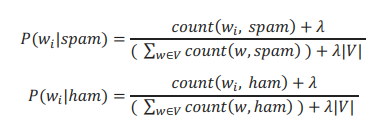

In [21]:
def laplace_smoothing(most_common_word, train_set, vocab):
    likelihood_vector = np.zeros(len(most_common_word))
    word_count = vocabulary(train_set) 
    total_word_count = sum(word_count.values()) # total number of words in spam/ham

    # Defining the smoothing parameter k
    k = 1
    word_freq = 0
    for i in range(len(most_common_word)): 
        word = most_common_word[i][0]
        # if the word does not appear in the word_count dictionary, put 0 
        if word not in word_count:
            word_count[word] = 0
        else:
            word_freq = word_count[word]  # number of times the word appears in word_count(spam or ham) dictionary

        # computing for the likelihoods
        # P(word1|spam) = (count of word1 belonging to category spam/ham + k)/(total count of words belonging to spam/ham + no of distinct words in training data)
        likelihood_vector[i] = (word_freq + k)/(total_word_count + k*len(vocab))
    return likelihood_vector


#### Computing likelihood of each word for spam

In [22]:
ham_likelihood_vector = laplace_smoothing(most_common_word, ham_train['email_text'], vocab)
ham_likelihood_vector

array([1.51694651e-04, 4.56426383e-05, 5.77245131e-05, ...,
       1.74515970e-05, 1.74515970e-05, 1.74515970e-05])

#### Computing likelihood of each word for ham

In [23]:
spam_likelihood_vector = laplace_smoothing(most_common_word, spam_train['email_text'], vocab)
spam_likelihood_vector

array([2.57458540e-02, 1.58069873e-02, 9.55066890e-03, ...,
       5.64423272e-06, 5.64423272e-06, 5.64423272e-06])

## Classifying the emails (10 points + 10 points for computing the log probabilities)
Determining the probability of ham and spam given the email. Whichever has the higher value will be the classificatin of the email. Attached is a guide on how to perform classification.


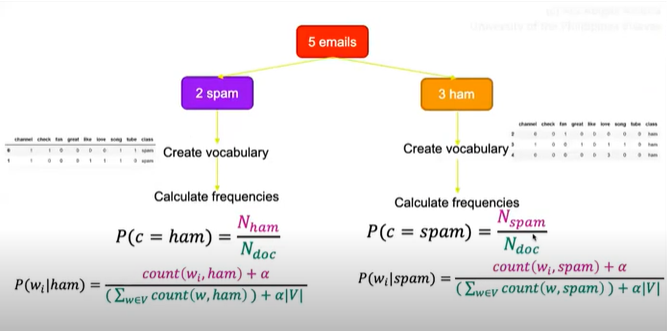

In [24]:
def email_classification(emails, most_common_word, ham_likelihood_vector, spam_likelihood_vector, prior_ham, prior_spam):
    #list that will hold the predictions
    prediction = []                               
    dic_features = dict(most_common_word)
    #list of features based on the most common word
    list_features = list(dic_features.keys())     
    
    # Iterate over emails in the dataset
    for mail in emails:
        # Initialize the variables
        prob_ham = 0
        prob_spam = 0
        # create tokens
        tokens = str(mail).split()
        for token in tokens:
            if token in list_features:
                # adding the likelihoods
                index_no = list_features.index(token)
                l_ham = ham_likelihood_vector[index_no]
                l_spam = spam_likelihood_vector[index_no]
                prob_ham += np.log(l_ham)
                prob_spam += np.log(l_spam)
        # adding the prior probabilities
        prob_ham+=np.log(prior_ham)
        prob_spam+=np.log(prior_spam)
        
        # find the classifier with the higher probability
        if prob_ham > prob_spam:
            classification = 0    #spam
            prediction.append(classification)
        elif prob_spam > prob_ham:
            classification = 1    #ham
            prediction.append(classification)
            
    return prediction

#### Email classification using train set

In [25]:
# Prediction of the model using train set
prediction_train = email_classification(train_set['email_text'], most_common_word, ham_likelihood_vector, spam_likelihood_vector, prior_ham, prior_spam)

# add a prediction column to the training set
train_set['prediction'] = prediction_train
train_set.head(10)

C:\Users\User\AppData\Local\Temp/ipykernel_5860/1648564358.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set['prediction'] = prediction_train


label                                         email_text  labeling  \
0   ham  mailing list queried weeks ago running set arc...         0   
1  spam  luxury watches buy rolex rolex cartier bvlgari...         1   
2  spam  academic qualifications prestigious acc redite...         1   
3   ham  greetings verify subscription plan fans list c...         0   
4  spam  guyton sheena will help mortgage loan loan see...         1   
5   ham           quiet quiet well straw poll plan running         0   
6   ham  working departed totally bell labs recommended...         0   
7  spam  nbc today body diet beaches magazines hollywoo...         1   
8  spam  oil sector going crazy weekly gift kkpt thing ...         1   
9  spam  magic perfect weekends http othxu rzfzwiwwfoeh...         1   

   prediction  
0           0  
1           1  
2           1  
3           0  
4           1  
5           0  
6           0  
7           1  
8           1  
9           1

## Testing the Classifier (10 points)

In [26]:
prediction_test = email_classification(test_set['email_text'], most_common_word, ham_likelihood_vector, spam_likelihood_vector, prior_ham, prior_spam)
# add a prediction column to the testing set
test_set['prediction'] = prediction_test
test_set.head(10)

C:\Users\User\AppData\Local\Temp/ipykernel_5860/2267060349.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set['prediction'] = prediction_test


label                                         email_text  labeling  \
21300  spam  ba df bc bc ba fc dd bf cc bd dd de ba bf bd d...         1   
21301   ham  things perform experiment display will remain ...         0   
21302  spam  best offer month viggra ci ialis vaiium xa naa...         1   
21303  spam  de ar wne cr doesn matter ow real st mmed ia t...         1   
21304  spam  ds body font size px color font family verdana...         1   
21305  spam  multi message mime format dragon content type ...         1   
21306  spam  delarosa alyssa will feeling happy med product...         1   
21307  spam  mistersporty incorporation rambrantplein ad de...         1   
21308  spam  choice best choice drugs viagra pill viagra so...         1   
21309   ham  ve changed dmdx listserv subject filter hopefu...         0   

       prediction  
21300           1  
21301           0  
21302           1  
21303           1  
21304           1  
21305           1  
21306           1  
21307           1  
21308           1  
21309           0

## Performance Evaluation (10 points)

In [27]:
# using sci-kit learn
y_test = np.array(test_set['labeling'])
y_pred = np.array(test_set['prediction'])

# Evaluate using accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: ", accuracy)

# Evaluate using recall
recall = recall_score(y_test, y_pred)
print("Recall: ", recall)

# Evaluate using precision
precision = precision_score(y_test, y_pred)
print("Precision: ", precision)

# Evaluation using confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

Accuracy:  0.9208328289553322
Recall:  0.9110911540188594
Precision:  0.9696071872311957
Confusion Matrix:
 [[ 5069   318]
 [  990 10145]]


# Results and Discussion

1. What is the effect of removing stop words in terms of precision, recall, and accuracy? Show a plot or a table of these results.

#### Without removing the stop words

In [28]:
# Load the data

uncleaned_df = pd.read_csv("labels.txt", sep=' ', names=['label', 'email_text'])
print("Size of the data:", df.shape)
df.head()

Size of the data: (37822, 3)


label                                         email_text  labeling
0   ham  mailing list queried weeks ago running set arc...         0
1  spam  luxury watches buy rolex rolex cartier bvlgari...         1
2  spam  academic qualifications prestigious acc redite...         1
3   ham  greetings verify subscription plan fans list c...         0
4  spam  guyton sheena will help mortgage loan loan see...         1

In [29]:
# 0 represents 'ham' and 1 represents 'spam'
uncleaned_df['labeling'] = uncleaned_df.label.map({'ham':0, 'spam':1})

In [30]:
# Remove words that are irrelevant as well as the alphanumberic characters, and punctuation marks
def preprocess_email(email_body):
    email_body = str(email_body).lower()
    
    # removing all whitespaces
    email_body = re.sub(r'\s+',' ', email_body) # remove whitespaces
    
    # removing html tags
    tags = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    email_body = re.sub(tags, '', email_body)
    
    # removing escape characters 
    ansi_escape =re.compile(r'(\x9B|\x1B\[)[0-?]*[ -\/]*[@-~]')
    email_body = ansi_escape.sub('', email_body)
    
    # remove all characters except alphabets and digits
    email_body = re.sub(r'[^A-Za-z0-9]+', ' ', email_body)
    
    # remove digits
    email_body = re.sub(r'[0-9]',' ',email_body)
   
    return email_body

In [31]:
directory = "data"
uncleaned_target_list = []
i = 0

for root, d_names, f_names in os.walk(directory):
    for file in f_names:
        # make path
        file_path = os.path.join(root, file)
        
        with open(file_path, 'rb') as f:
            # Parse the email message
            msg = email.message_from_binary_file(f)
            body = ""
            
            # Extract the body of the email
            if msg.is_multipart():
                for payload in msg.get_payload():
                    body = payload.get_payload()
            # if it is not multipart, immediately get the message
            else:
                body = msg.get_payload()
            # Clean the email body
            cleaned_body = preprocess_email(body)
            if i != 0:
                uncleaned_target_list.append(cleaned_body)
            else:
                i+=1     

In [32]:
uncleaned_df['email_text'] = uncleaned_target_list
uncleaned_df.head(10)

label                                         email_text  labeling
0   ham  the mailing list i queried about a few weeks a...         0
1  spam   luxury watches buy your own rolex for only   ...         1
2  spam  academic qualifications available from prestig...         1
3   ham  greetings all this is to verify your subscript...         0
4  spam   guyton sheena we will help you get the mortga...         1
5   ham  it s quiet too quiet well how about a straw po...         0
6   ham  it s working here i have departed almost total...         0
7  spam  from nbc today show it s the look everyone wan...         1
8  spam  the oil sector is going crazy this is our week...         1
9  spam  little magic perfect weekends http othxu rzfzw...         1

In [33]:
# Split the dataset into three groups: training set for ham, training set for spam, and the testing set

# Splitting the dataset into a training and testing set first
uncleaned_train_set = uncleaned_df[:21300]
uncleaned_test_set = uncleaned_df[21300:]

# group by label: spam or ham 
group_train = uncleaned_train_set.groupby('label')
# training set for ham, training set for spam
uncleaned_ham_train = group_train.get_group('ham')
uncleaned_spam_train = group_train.get_group('spam')

In [34]:
uncleaned_vocab = vocabulary(uncleaned_train_set['email_text'])
# sort the dictionary according to the top 10,000 words
uncleaned_most_common_word = sorted(uncleaned_vocab.items(), key=lambda x:-x[1])[:10000]
uncleaned_most_common_word

[('e', 203527),
 ('a', 139668),
 ('the', 134199),
 ('f', 123283),
 ('b', 122820),
 ('to', 87125),
 ('c', 72957),
 ('and', 68583),
 ('i', 67404),
 ('d', 66581),
 ('of', 60112),
 ('in', 42313),
 ('ee', 41277),
 ('is', 37745),
 ('you', 34220),
 ('s', 33275),
 ('l', 33131),
 ('for', 32039),
 ('ed', 29385),
 ('it', 28006),
 ('that', 25864),
 ('px', 25271),
 ('this', 24003),
 ('g', 22779),
 ('on', 22377),
 ('j', 21540),
 ('with', 21531),
 ('t', 21485),
 ('be', 21165),
 ('n', 20133),
 ('m', 19774),
 ('from', 19624),
 ('o', 19541),
 ('v', 18663),
 ('p', 18204),
 ('k', 17760),
 ('r', 17335),
 ('have', 16537),
 ('h', 16460),
 ('are', 15662),
 ('x', 15594),
 ('eb', 15313),
 ('your', 15128),
 ('ea', 15052),
 ('as', 14866),
 ('by', 14775),
 ('we', 14140),
 ('ec', 14128),
 ('at', 14055),
 ('y', 13891),
 ('http', 13817),
 ('com', 13817),
 ('z', 13696),
 ('or', 13677),
 ('not', 12474),
 ('will', 12355),
 ('font', 11780),
 ('ef', 11706),
 ('my', 11592),
 ('edu', 11553),
 ('w', 11357),
 ('u', 11346),
 (

In [35]:
uncleaned_spam_feature_matrix = np.array(count_matrix(uncleaned_spam_train['email_text'], uncleaned_most_common_word))

In [36]:
uncleaned_ham_feature_matrix = np.array(count_matrix(uncleaned_ham_train['email_text'], uncleaned_most_common_word))

In [37]:
# Getting the count of ham and spam emails and the total count of email in the training set
uncleaned_ham_count = len(uncleaned_ham_train)
uncleaned_spam_count = len(uncleaned_spam_train)
uncleaned_email_count = len(uncleaned_train_set)

# probability of spam
uncleaned_prior_spam = prior_probabilities(uncleaned_spam_count, uncleaned_email_count)
print("Prior probabilities for spam: ", uncleaned_prior_spam)

# probability of ham
uncleaned_prior_ham = prior_probabilities(uncleaned_ham_count, uncleaned_email_count)
print("Prior probabilities for ham: ", uncleaned_prior_ham)

Prior probabilities for spam:  0.6468075117370892
Prior probabilities for ham:  0.3531924882629108


In [38]:
uncleaned_ham_likelihood_vector = laplace_smoothing(uncleaned_most_common_word, uncleaned_ham_train['email_text'], uncleaned_vocab)
uncleaned_ham_likelihood_vector

array([3.29264781e-03, 1.68131566e-02, 3.51701341e-02, ...,
       9.12828319e-06, 5.32483186e-06, 1.52138053e-06])

In [39]:
uncleaned_spam_likelihood_vector = laplace_smoothing(uncleaned_most_common_word, uncleaned_spam_train['email_text'], uncleaned_vocab)
uncleaned_spam_likelihood_vector

array([6.21738713e-02, 3.04580885e-02, 1.33145860e-02, ...,
       1.59524897e-06, 4.78574690e-06, 7.97624483e-06])

In [40]:
# Prediction of the model using train set
uncleaned_prediction_train = email_classification(uncleaned_train_set['email_text'], uncleaned_most_common_word, uncleaned_ham_likelihood_vector, uncleaned_spam_likelihood_vector, uncleaned_prior_ham, uncleaned_prior_spam)

# add a prediction column to the training set
uncleaned_train_set['prediction'] = uncleaned_prediction_train
uncleaned_train_set.head(10)

C:\Users\User\AppData\Local\Temp/ipykernel_5860/4040709055.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uncleaned_train_set['prediction'] = uncleaned_prediction_train


label                                         email_text  labeling  \
0   ham  the mailing list i queried about a few weeks a...         0   
1  spam   luxury watches buy your own rolex for only   ...         1   
2  spam  academic qualifications available from prestig...         1   
3   ham  greetings all this is to verify your subscript...         0   
4  spam   guyton sheena we will help you get the mortga...         1   
5   ham  it s quiet too quiet well how about a straw po...         0   
6   ham  it s working here i have departed almost total...         0   
7  spam  from nbc today show it s the look everyone wan...         1   
8  spam  the oil sector is going crazy this is our week...         1   
9  spam  little magic perfect weekends http othxu rzfzw...         1   

   prediction  
0           0  
1           1  
2           1  
3           0  
4           0  
5           0  
6           0  
7           0  
8           1  
9           1

In [41]:
uncleaned_prediction_test = email_classification(uncleaned_test_set['email_text'], uncleaned_most_common_word, uncleaned_ham_likelihood_vector, uncleaned_spam_likelihood_vector, uncleaned_prior_ham, uncleaned_prior_spam)
# add a prediction column to the testing set
uncleaned_test_set['prediction'] = uncleaned_prediction_test
uncleaned_test_set.head(10)

C:\Users\User\AppData\Local\Temp/ipykernel_5860/3753183822.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uncleaned_test_set['prediction'] = uncleaned_prediction_test


label                                         email_text  labeling  \
21300  spam    d  d  d  d  d  d  d  d  d  d  d  d  d  d  d ...         1   
21301   ham   there are several things you can use to perfo...         0   
21302  spam   best offer of the month viggra       ci ialis...         1   
21303  spam   de i ar home o h wne n r your cr v ed b it do...         1   
21304  spam   ds body font size   px color     font family ...         1   
21305  spam  this is a multi part message in mime format   ...         1   
21306  spam   delarosa alyssa you will be feeling happy by ...         1   
21307  spam  the mistersporty incorporation rambrantplein  ...         1   
21308  spam   ed choice your best choice for ed drugs viagr...         1   
21309   ham   i ve changed the dmdx listserv subject filter...         0   

       prediction  
21300           1  
21301           0  
21302           1  
21303           1  
21304           1  
21305           1  
21306           1  
21307           0  
21308           1  
21309           0

In [42]:
# using sci-kit learn
y_test = np.array(uncleaned_test_set['labeling'])
y_pred = np.array(uncleaned_test_set['prediction'])

# Evaluate using accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: ", accuracy)

# Evaluate using recall
recall = recall_score(y_test, y_pred)
print("Recall: ", recall)

# Evaluate using precision
precision = precision_score(y_test, y_pred)
print("Precision: ", precision)

# Evaluation using confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

Accuracy:  0.869083646047694
Recall:  0.8422092501122587
Precision:  0.9585036794766967
Confusion Matrix:
 [[4981  406]
 [1757 9378]]


In [47]:
# result with removing the stop words
result_remove_stop_words = {'Accuracy': 0.92, 'Precision': 0.97, 'Recall':0.91}
# result without removing the stop words
result_with_stop_words = {'Accuracy': accuracy, 'Precision': precision, 'Recall':recall}

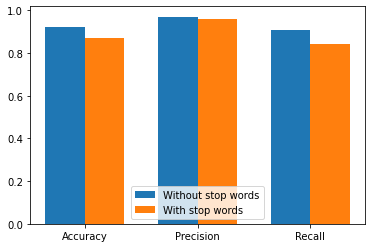

In [48]:
# creating bar plot
fig, ax = plt.subplots()
index = np.arange(len(result_remove_stop_words))
bar_width = 0.35

# Plot the first result
rects1 = ax.bar(index, result_remove_stop_words.values(), bar_width, label='Without stop words')

# Plot the second result
rects2 = ax.bar(index + bar_width, result_with_stop_words.values(), bar_width, label='With stop words')

# Set the X-axis labels
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(result_remove_stop_words.keys())

# Add a legend
ax.legend()

# Show the plot
plt.show()

2. Experiment on the number of words used for training. Filter the dictionary to include only words occurring more than k times (1000 words, then k > 100, and k = 50 times). For example, the word “offer” appears 150 times, that means that it will be included in the dictionary.

Filtering the words in a dictionary will surely significantly affect the result of the prediction. Filtering words is not recommended most of the time since the length of the word is not that important to improve predictions. There are shorter and longer words that are significant in the dataset so removing those words would negatively affect our predictions. 

3. Discuss the results of the different parameters used for Lambda smoothing. Test it on 5 varying values of the λ (e.g. λ = 2.0, 1.0, 0.5, 0.1, 0.005), Evaluate performance metrics for each.

It is preferred to use alpha=1, to avoid zero probability. Since, as alpha increases, the likelihood would move towards a uniform distribution.

4. What are your recommendations to further improve the model?

To further improve the model, data should be thoroughly cleaned. In our implementation, there are words that don’t make sense at all. Data preprocessing and feature selection should be improved to make the model faster and more accurate. 